# TV Script Generation

In this project, you'll generate your own [Seinfeld](https://en.wikipedia.org/wiki/Seinfeld) TV scripts using RNNs.  You'll be using part of the [Seinfeld dataset](https://www.kaggle.com/thec03u5/seinfeld-chronicles#scripts.csv) of scripts from 9 seasons.  The Neural Network you'll build will generate a new ,"fake" TV script, based on patterns it recognizes in this training data.

## Get the Data

The data is already provided for you in `./data/Seinfeld_Scripts.txt` and you're encouraged to open that file and look at the text. 
>* As a first step, we'll load in this data and look at some samples. 
* Then, you'll be tasked with defining and training an RNN to generate a new script!

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# load in data
import helper
data_dir = './data/Seinfeld_Scripts.txt'
text = helper.load_data(data_dir)

## Explore the Data
Play around with `view_line_range` to view different parts of the data. This will give you a sense of the data you'll be working with. You can see, for example, that it is all lowercase text, and each new line of dialogue is separated by a newline character `\n`.

In [17]:
view_line_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()})))

lines = text.split('\n')
print('Number of lines: {}'.format(len(lines)))
word_count_line = [len(line.split()) for line in lines]
print('Average number of words in each line: {}'.format(np.average(word_count_line)))

print()
print('The lines {} to {}:'.format(*view_line_range))
print('\n'.join(text.split('\n')[view_line_range[0]:view_line_range[1]]))

Dataset Stats
Roughly the number of unique words: 46367
Number of lines: 109233
Average number of words in each line: 5.544240293684143

The lines 0 to 10:
jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! y

---
## Implement Pre-processing Functions
The first thing to do to any dataset is pre-processing.  Implement the following pre-processing functions below:
- Lookup Table
- Tokenize Punctuation

### Lookup Table
To create a word embedding, you first need to transform the words to ids.  In this function, create two dictionaries:
- Dictionary to go from the words to an id, we'll call `vocab_to_int`
- Dictionary to go from the id to word, we'll call `int_to_vocab`

Return these dictionaries in the following **tuple** `(vocab_to_int, int_to_vocab)`

In [18]:
import problem_unittests as tests
from collections import Counter

def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    # TODO: Implement Function
    #From word embedding notebook
    word_counts = Counter(text)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
        
    # return tuple
    return (vocab_to_int, int_to_vocab)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_create_lookup_tables(create_lookup_tables)

Tests Passed


### Tokenize Punctuation
We'll be splitting the script into a word array using spaces as delimiters.  However, punctuations like periods and exclamation marks can create multiple ids for the same word. For example, "bye" and "bye!" would generate two different word ids.

Implement the function `token_lookup` to return a dict that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".  Create a dictionary for the following symbols where the symbol is the key and value is the token:
- Period ( **.** )
- Comma ( **,** )
- Quotation Mark ( **"** )
- Semicolon ( **;** )
- Exclamation mark ( **!** )
- Question mark ( **?** )
- Left Parentheses ( **(** )
- Right Parentheses ( **)** )
- Dash ( **-** )
- Return ( **\n** )

This dictionary will be used to tokenize the symbols and add the delimiter (space) around it.  This separates each symbols as its own word, making it easier for the neural network to predict the next word. Make sure you don't use a value that could be confused as a word; for example, instead of using the value "dash", try using something like "||dash||".

In [19]:
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenized dictionary where the key is the punctuation and the value is the token
    """
    # TODO: Implement Function
    mapping ={
        ".":"||Period||",
        ",":"||Comma||",
        '"':"||Quotation_Mark||",
        ";":"||Semi_Colon||",
        "!":"||Exclamation_Mark||",
        "?":"||Question_Mark||",
        "(":"||Left_Parentheses||",
        ")":"||Right_Parentheses||",
        "-":"||Dash||",
        "\n":"||Return||"
    }
    return mapping

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_tokenize(token_lookup)

Tests Passed


## Pre-process all the data and save it

Running the code cell below will pre-process all the data and save it to file. You're encouraged to lok at the code for `preprocess_and_save_data` in the `helpers.py` file to see what it's doing in detail, but you do not need to change this code.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# pre-process training data
helper.preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

## Build the Neural Network
In this section, you'll build the components necessary to build an RNN by implementing the RNN Module and forward and backpropagation functions.

### Check Access to GPU

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

## Input
Let's start with the preprocessed input data. We'll use [TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) to provide a known format to our dataset; in combination with [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader), it will handle batching, shuffling, and other dataset iteration functions.

You can create data with TensorDataset by passing in feature and target tensors. Then create a DataLoader as usual.
```
data = TensorDataset(feature_tensors, target_tensors)
data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=batch_size)
```

### Batching
Implement the `batch_data` function to batch `words` data into chunks of size `batch_size` using the `TensorDataset` and `DataLoader` classes.

>You can batch words using the DataLoader, but it will be up to you to create `feature_tensors` and `target_tensors` of the correct size and content for a given `sequence_length`.

For example, say we have these as input:
```
words = [1, 2, 3, 4, 5, 6, 7]
sequence_length = 4
```

Your first `feature_tensor` should contain the values:
```
[1, 2, 3, 4]
```
And the corresponding `target_tensor` should just be the next "word"/tokenized word value:
```
5
```
This should continue with the second `feature_tensor`, `target_tensor` being:
```
[2, 3, 4, 5]  # features
6             # target
```

In [23]:
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

def batch_data(words, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader
    :param words: The word ids of the TV scripts
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    # TODO: Implement function
    nb_words=len(words)
    n_batches = nb_words//(sequence_length*batch_size)
    feature_tensors=torch.Tensor(words[0:n_batches*sequence_length*batch_size])
    
    feature_tensors=[]
    target_tensors = []
    
    for i in range(nb_words):
        try :
            #We put in the word coming after the sequence
            target_tensors.append(words[i+sequence_length])
            #We put in the sequence of words
            feature_tensors.append(words[i:i+sequence_length])
            
        except IndexError:
            #We ignore last elements that have noting to predict because we're at the edge
            pass
    # We convert everything into torch tensors
    feature_tensors=torch.Tensor(feature_tensors)
    target_tensors=torch.Tensor(target_tensors)
    
    #We print some statistics
    print("Features size : ",feature_tensors.shape)
    print("Targets size : ",target_tensors.shape)
    print("Number of batches : ",n_batches)
    print("Number of entries : ",len(feature_tensors))
    
    #we create the dataset
    data = TensorDataset(feature_tensors, target_tensors)
    #We create the dataloader
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle=True)
    # return a dataloader
    return data_loader

# there is no test for this function, but you are encouraged to create
# print statements and tests of your own

batch_data(int_text,20,3)

Features size :  torch.Size([892090, 20])
Targets size :  torch.Size([892090])
Number of batches :  14868
Number of entries :  892090


### Test your dataloader 

You'll have to modify this code to test a batching function, but it should look fairly similar.

Below, we're generating some test text data and defining a dataloader using the function you defined, above. Then, we are getting some sample batch of inputs `sample_x` and targets `sample_y` from our dataloader.

Your code should return something like the following (likely in a different order, if you shuffled your data):

```
torch.Size([10, 5])
tensor([[ 28,  29,  30,  31,  32],
        [ 21,  22,  23,  24,  25],
        [ 17,  18,  19,  20,  21],
        [ 34,  35,  36,  37,  38],
        [ 11,  12,  13,  14,  15],
        [ 23,  24,  25,  26,  27],
        [  6,   7,   8,   9,  10],
        [ 38,  39,  40,  41,  42],
        [ 25,  26,  27,  28,  29],
        [  7,   8,   9,  10,  11]])

torch.Size([10])
tensor([ 33,  26,  22,  39,  16,  28,  11,  43,  30,  12])
```

### Sizes
Your sample_x should be of size `(batch_size, sequence_length)` or (10, 5) in this case and sample_y should just have one dimension: batch_size (10). 

### Values

You should also notice that the targets, sample_y, are the *next* value in the ordered test_text data. So, for an input sequence `[ 28,  29,  30,  31,  32]` that ends with the value `32`, the corresponding output should be `33`.

In [24]:
# test dataloader

test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

Features size :  torch.Size([45, 5])
Targets size :  torch.Size([45])
Number of batches :  1
Number of entries :  45
torch.Size([10, 5])
tensor([[ 7.,  8.,  9., 10., 11.],
        [ 0.,  1.,  2.,  3.,  4.],
        [38., 39., 40., 41., 42.],
        [26., 27., 28., 29., 30.],
        [42., 43., 44., 45., 46.],
        [11., 12., 13., 14., 15.],
        [ 3.,  4.,  5.,  6.,  7.],
        [36., 37., 38., 39., 40.],
        [19., 20., 21., 22., 23.],
        [15., 16., 17., 18., 19.]])

torch.Size([10])
tensor([12.,  5., 43., 31., 47., 16.,  8., 41., 24., 20.])


---
## Build the Neural Network
Implement an RNN using PyTorch's [Module class](http://pytorch.org/docs/master/nn.html#torch.nn.Module). You may choose to use a GRU or an LSTM. To complete the RNN, you'll have to implement the following functions for the class:
 - `__init__` - The initialize function. 
 - `init_hidden` - The initialization function for an LSTM/GRU hidden state
 - `forward` - Forward propagation function.
 
The initialize function should create the layers of the neural network and save them to the class. The forward propagation function will use these layers to run forward propagation and generate an output and a hidden state.

**The output of this model should be the *last* batch of word scores** after a complete sequence has been processed. That is, for each input sequence of words, we only want to output the word scores for a single, most likely, next word.

### Hints

1. Make sure to stack the outputs of the lstm to pass to your fully-connected layer, you can do this with `lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim)`
2. You can get the last batch of word scores by shaping the output of the final, fully-connected layer like so:

```
# reshape into (batch_size, seq_length, output_size)
output = output.view(batch_size, -1, self.output_size)
# get last batch
out = output[:, -1]
```

In [77]:
import torch.nn as nn
import torch.nn.functional as F
class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        """
        Initialize the PyTorch RNN Module
        :param vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        :param output_size: The number of output dimensions of the neural network
        :param embedding_dim: The size of embeddings, should you choose to use them        
        :param hidden_dim: The size of the hidden layer outputs
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(RNN, self).__init__()
        # TODO: Implement function
        
        # set class variables
        self.dropout = dropout
        self.vocab_size = vocab_size
        self.embedding_dim=embedding_dim
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.output_size=output_size
        
        
        # define model layers
        self.embed= nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim,self.output_size)
    
    
    def forward(self, nn_input, hidden):
        """
        Forward propagation of the neural network
        :param nn_input: The input to the neural network
        :param hidden: The hidden state        
        :return: Two Tensors, the output of the neural network and the latest hidden state
        """
        # TODO: Implement function
        
        batch_size = nn_input.size(0)
        
        #Go through embedding layer
        nn_input=nn_input.long()
        emb = self.embed(nn_input)

        #Pass the vector representation of the word through the lstm
        r_out, hidden = self.lstm(emb,hidden)
        
        
        #Resize so it can go in the fc layer
        #Only last element of the sequence output has to go through the fc layer, because that's where we get the output
        #Other elements of the sequence just permit us to get the hidden state up for the prediction.
        r_out = r_out[:,-1,:].contiguous().view(-1,self.hidden_dim)
        
        out = self.fc(r_out)
        
        #out = F.softmax(out,dim=1)
        # return one batch of output word scores and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Implement function
        
        # initialize hidden state with zero weights, and move to GPU if available
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_rnn(RNN, train_on_gpu)

Tests Passed


### Define forward and backpropagation

Use the RNN class you implemented to apply forward and back propagation. This function will be called, iteratively, in the training loop as follows:
```
loss = forward_back_prop(decoder, decoder_optimizer, criterion, inp, target)
```

And it should return the average loss over a batch and the hidden state returned by a call to `RNN(inp, hidden)`. Recall that you can get this loss by computing it, as usual, and calling `loss.item()`.

**If a GPU is available, you should move your data to that GPU device, here.**

In [128]:
def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden):
    """
    Forward and backward propagation on the neural network
    :param rnn: The PyTorch Module that holds the neural network
    :param optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    
    # TODO: Implement Function
    
    # move data to GPU, if available
    target=target.long()
    if(train_on_gpu):
        inp = inp.cuda()
        target=target.cuda()
    
    hidden = tuple([each.data for each in hidden])
    rnn.zero_grad()
    out, hidden= rnn(inp,hidden)
    
    # perform backpropagation and optimization
    loss= criterion(out,target)
    
    loss.backward()
    
    nn.utils.clip_grad_norm_(rnn.parameters(), 5)
    
    optimizer.step()
    # return the loss over a batch and the hidden state produced by our model
    return loss.item(), hidden

# Note that these tests aren't completely extensive.
# they are here to act as general checks on the expected outputs of your functions
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_forward_back_prop(RNN, forward_back_prop, train_on_gpu)

Tests Passed


## Neural Network Training

With the structure of the network complete and data ready to be fed in the neural network, it's time to train it.

### Train Loop

The training loop is implemented for you in the `train_decoder` function. This function will train the network over all the batches for the number of epochs given. The model progress will be shown every number of batches. This number is set with the `show_every_n_batches` parameter. You'll set this parameter along with other parameters in the next section.

In [129]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

            # printing loss stats
            if batch_i % show_every_n_batches == 0:
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(
                    epoch_i, n_epochs, np.average(batch_losses)))
                batch_losses = []

    # returns a trained rnn
    return rnn

### Hyperparameters

Set and train the neural network with the following parameters:
- Set `sequence_length` to the length of a sequence.
- Set `batch_size` to the batch size.
- Set `num_epochs` to the number of epochs to train for.
- Set `learning_rate` to the learning rate for an Adam optimizer.
- Set `vocab_size` to the number of unique tokens in our vocabulary.
- Set `output_size` to the desired size of the output.
- Set `embedding_dim` to the embedding dimension; smaller than the vocab_size.
- Set `hidden_dim` to the hidden dimension of your RNN.
- Set `n_layers` to the number of layers/cells in your RNN.
- Set `show_every_n_batches` to the number of batches at which the neural network should print progress.

If the network isn't getting the desired results, tweak these parameters and/or the layers in the `RNN` class.

In [130]:
# Data params
# Sequence Length
sequence_length = 12  # of words in a sequence
# Batch Size
batch_size = 80

# data loader - do not change
train_loader = batch_data(int_text, sequence_length, batch_size)

Features size :  torch.Size([892098, 12])
Targets size :  torch.Size([892098])
Number of batches :  929
Number of entries :  892098


In [131]:
# Training parameters
# Number of Epochs
num_epochs = 10
# Learning Rate
learning_rate = 0.0005

# Model parameters
# Vocab size
vocab_size = len(vocab_to_int)
# Output size
output_size = len(vocab_to_int)
# Embedding Dimension
embedding_dim = 200
# Hidden Dimension
hidden_dim = 512
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 500

### Train
In the next cell, you'll train the neural network on the pre-processed data.  If you have a hard time getting a good loss, you may consider changing your hyperparameters. In general, you may get better results with larger hidden and n_layer dimensions, but larger models take a longer time to train. 
> **You should aim for a loss less than 3.5.** 

You should also experiment with different sequence lengths, which determine the size of the long range dependencies that a model can learn.

In [132]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

Training for 10 epoch(s)...
Epoch:    1/10    Loss: 5.519789922714233

Epoch:    1/10    Loss: 4.962791416168213

Epoch:    1/10    Loss: 4.737557822227478

Epoch:    1/10    Loss: 4.608646265029908

Epoch:    1/10    Loss: 4.506006414890289

Epoch:    1/10    Loss: 4.427857810974121

Epoch:    1/10    Loss: 4.409191601276397

Epoch:    1/10    Loss: 4.330467197418213

Epoch:    1/10    Loss: 4.334769406795502

Epoch:    1/10    Loss: 4.272748074531555

Epoch:    1/10    Loss: 4.210116692066193

Epoch:    1/10    Loss: 4.223255338668824

Epoch:    1/10    Loss: 4.209183578014374

Epoch:    1/10    Loss: 4.170458958148957

Epoch:    1/10    Loss: 4.162810853004456

Epoch:    1/10    Loss: 4.166756516456604

Epoch:    1/10    Loss: 4.11368896150589

Epoch:    1/10    Loss: 4.12159386253357

Epoch:    1/10    Loss: 4.085053715705872

Epoch:    1/10    Loss: 4.091104840278626

Epoch:    1/10    Loss: 4.058031815052033

Epoch:    1/10    Loss: 4.07367617893219

Epoch:    2/10    Loss: 3.899

Epoch:    9/10    Loss: 3.1273612360954286

Epoch:    9/10    Loss: 3.1499884552955626

Epoch:    9/10    Loss: 3.1443096227645873

Epoch:    9/10    Loss: 3.142569321632385

Epoch:    9/10    Loss: 3.1938859920501708

Epoch:    9/10    Loss: 3.1730124506950377

Epoch:    9/10    Loss: 3.1966968960762023

Epoch:    9/10    Loss: 3.2029829111099244

Epoch:    9/10    Loss: 3.2422829189300537

Epoch:   10/10    Loss: 3.000526728534845

Epoch:   10/10    Loss: 2.9416187038421633

Epoch:   10/10    Loss: 2.978934675693512

Epoch:   10/10    Loss: 2.9783016605377197

Epoch:   10/10    Loss: 2.9819813838005067

Epoch:   10/10    Loss: 2.9897988629341126

Epoch:   10/10    Loss: 3.0163512091636657

Epoch:   10/10    Loss: 3.014340161323547

Epoch:   10/10    Loss: 3.0389675226211548

Epoch:   10/10    Loss: 3.051557569980621

Epoch:   10/10    Loss: 3.0294989943504333

Epoch:   10/10    Loss: 3.073694170951843

Epoch:   10/10    Loss: 3.0908339190483094

Epoch:   10/10    Loss: 3.101693218231

### Question: How did you decide on your model hyperparameters? 
For example, did you try different sequence_lengths and find that one size made the model converge faster? What about your hidden_dim and n_layers; how did you decide on those?

**Answer:** (Write answer, here)

First I tried some values according to the reccomendations in the hyperparameters section, i have chosen :
- lr = 0.001
- emb_dim = 300
- hidden_dim = 512
- n_layers = 3
- sequence_length =20
And I trained for 2 epochs, when i've seen that the loss started to be constant pretty fast, I tried changing the sequence_length to 15 and increasing lr to 0.003 and I trained for 3 epochs but i got the same problem.

I then thought that, given the first statistics we have ~5-6 words per line, which represents something someone said, so i thought i might need last sentence and part of the current sentence, so i took 2 lines : 2*6 = 12 words for the sequence_length. I also lowered embedding_dim to 200, changed the number of layers for the LSTM to 2 and set learning rate to 0.001.
After training for 3 epochs, i've seen that the loss stabilizes at 3.8, so i decided to train using a learning rate of 0.0005 for 10 epochs, which gave my final model that got the loss under 3.5 by the 4th epoch.


---
# Checkpoint

After running the above training cell, your model will be saved by name, `trained_rnn`, and if you save your notebook progress, **you can pause here and come back to this code at another time**. You can resume your progress by running the next cell, which will load in our word:id dictionaries _and_ load in your saved model by name!

In [133]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('./save/trained_rnn')

## Generate TV Script
With the network trained and saved, you'll use it to generate a new, "fake" Seinfeld TV script in this section.

### Generate Text
To generate the text, the network needs to start with a single word and repeat its predictions until it reaches a set length. You'll be using the `generate` function to do this. It takes a word id to start with, `prime_id`, and generates a set length of text, `predict_len`. Also note that it uses topk sampling to introduce some randomness in choosing the most likely next word, given an output set of word scores!

In [140]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import torch.nn.functional as F

def generate(rnn, prime_id, int_to_vocab, token_dict, pad_value, predict_len=100):
    """
    Generate text using the neural network
    :param decoder: The PyTorch Module that holds the trained neural network
    :param prime_id: The word id to start the first prediction
    :param int_to_vocab: Dict of word id keys to word values
    :param token_dict: Dict of puncuation tokens keys to puncuation values
    :param pad_value: The value used to pad a sequence
    :param predict_len: The length of text to generate
    :return: The generated text
    """
    rnn.eval()
    
    # create a sequence (batch_size=1) with the prime_id
    current_seq = np.full((1, sequence_length), pad_value)
    current_seq[-1][-1] = prime_id
    predicted = [int_to_vocab[prime_id]]
    rnn.cpu()
    
    for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)
        
        current_seq=current_seq.cpu()
        
        # initialize the hidden state
        hidden = rnn.init_hidden(current_seq.size(0))
        hidden= hidden[0].cpu(), hidden[1].cpu()
        
        # get the output of the rnn
        output, _ = rnn(current_seq, hidden)
        
        # get the next word probabilities
        p = F.softmax(output, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
         
        # use top_k sampling to get the index of the next word
        top_k = 5
        p, top_i = p.topk(top_k)
        top_i = top_i.numpy().squeeze()
        
        # select the likely next word index with some element of randomness
        p = p.numpy().squeeze()
        word_i = np.random.choice(top_i, p=p/p.sum())
        
        # retrieve that word from the dictionary
        word = int_to_vocab[word_i]
        predicted.append(word)     
        
        # the generated word becomes the next "current sequence" and the cycle can continue
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token.lower(), key)
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    # return all the sentences
    return gen_sentences

### Generate a New Script
It's time to generate the text. Set `gen_length` to the length of TV script you want to generate and set `prime_word` to one of the following to start the prediction:
- "jerry"
- "elaine"
- "george"
- "kramer"

You can set the prime word to _any word_ in our dictionary, but it's best to start with a name for generating a TV script. (You can also start with any other names you find in the original text file!)

In [141]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'jerry' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

jerry: penetrate penetrate whisper] up the hall and pretends for a second.

jerry: i can't believe this. i can't do anything. it's not my fault.

elaine: what?

george: what, are you going to eat the contract with me?(jerry enters)

jerry: so, what's going on in the hall?

george: no no no.

elaine: you don't have a problem with this.

elaine: i don't know how to drive.

jerry:(looking around) what?

elaine: well, you know, it's not a little burning.

jerry: oh, i know.(pause)

jerry: so you're gonna be able to do this?

elaine: yeah.

jerry:(sarcastic) oh.

george: hey, you know what this means?

kramer: oh, yeah, yeah.(to jerry) so, uh, what do you want me to do?

jerry: well, i'm sorry.

elaine: well, you don't wanna know that..

george: well, you know, i have a very good idea.

george: you know, i think i can go.

george: you know, the guy who has to tell me that she liked her, she handed me a phony, he was just trying to fix me up in my apartment, he's gonna have to go to work.(to

#### Save your favorite scripts

Once you have a script that you like (or find interesting), save it to a text file!

In [142]:
# save script to a text file
f =  open("generated_script_1.txt","w")
f.write(generated_script)
f.close()

# The TV Script is Not Perfect
It's ok if the TV script doesn't make perfect sense. It should look like alternating lines of dialogue, here is one such example of a few generated lines.

### Example generated script

>jerry: what about me?
>
>jerry: i don't have to wait.
>
>kramer:(to the sales table)
>
>elaine:(to jerry) hey, look at this, i'm a good doctor.
>
>newman:(to elaine) you think i have no idea of this...
>
>elaine: oh, you better take the phone, and he was a little nervous.
>
>kramer:(to the phone) hey, hey, jerry, i don't want to be a little bit.(to kramer and jerry) you can't.
>
>jerry: oh, yeah. i don't even know, i know.
>
>jerry:(to the phone) oh, i know.
>
>kramer:(laughing) you know...(to jerry) you don't know.

You can see that there are multiple characters that say (somewhat) complete sentences, but it doesn't have to be perfect! It takes quite a while to get good results, and often, you'll have to use a smaller vocabulary (and discard uncommon words), or get more data.  The Seinfeld dataset is about 3.4 MB, which is big enough for our purposes; for script generation you'll want more than 1 MB of text, generally. 

# Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_tv_script_generation.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "helper.py" and "problem_unittests.py" files in your submission. Once you download these files, compress them into one zip file for submission.

## Visualizing learned word embeddings

In [143]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [145]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# getting embeddings from the embedding layer of our model, by name
embeddings = trained_rnn.embed.weight.to('cpu').data.numpy()




In [146]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

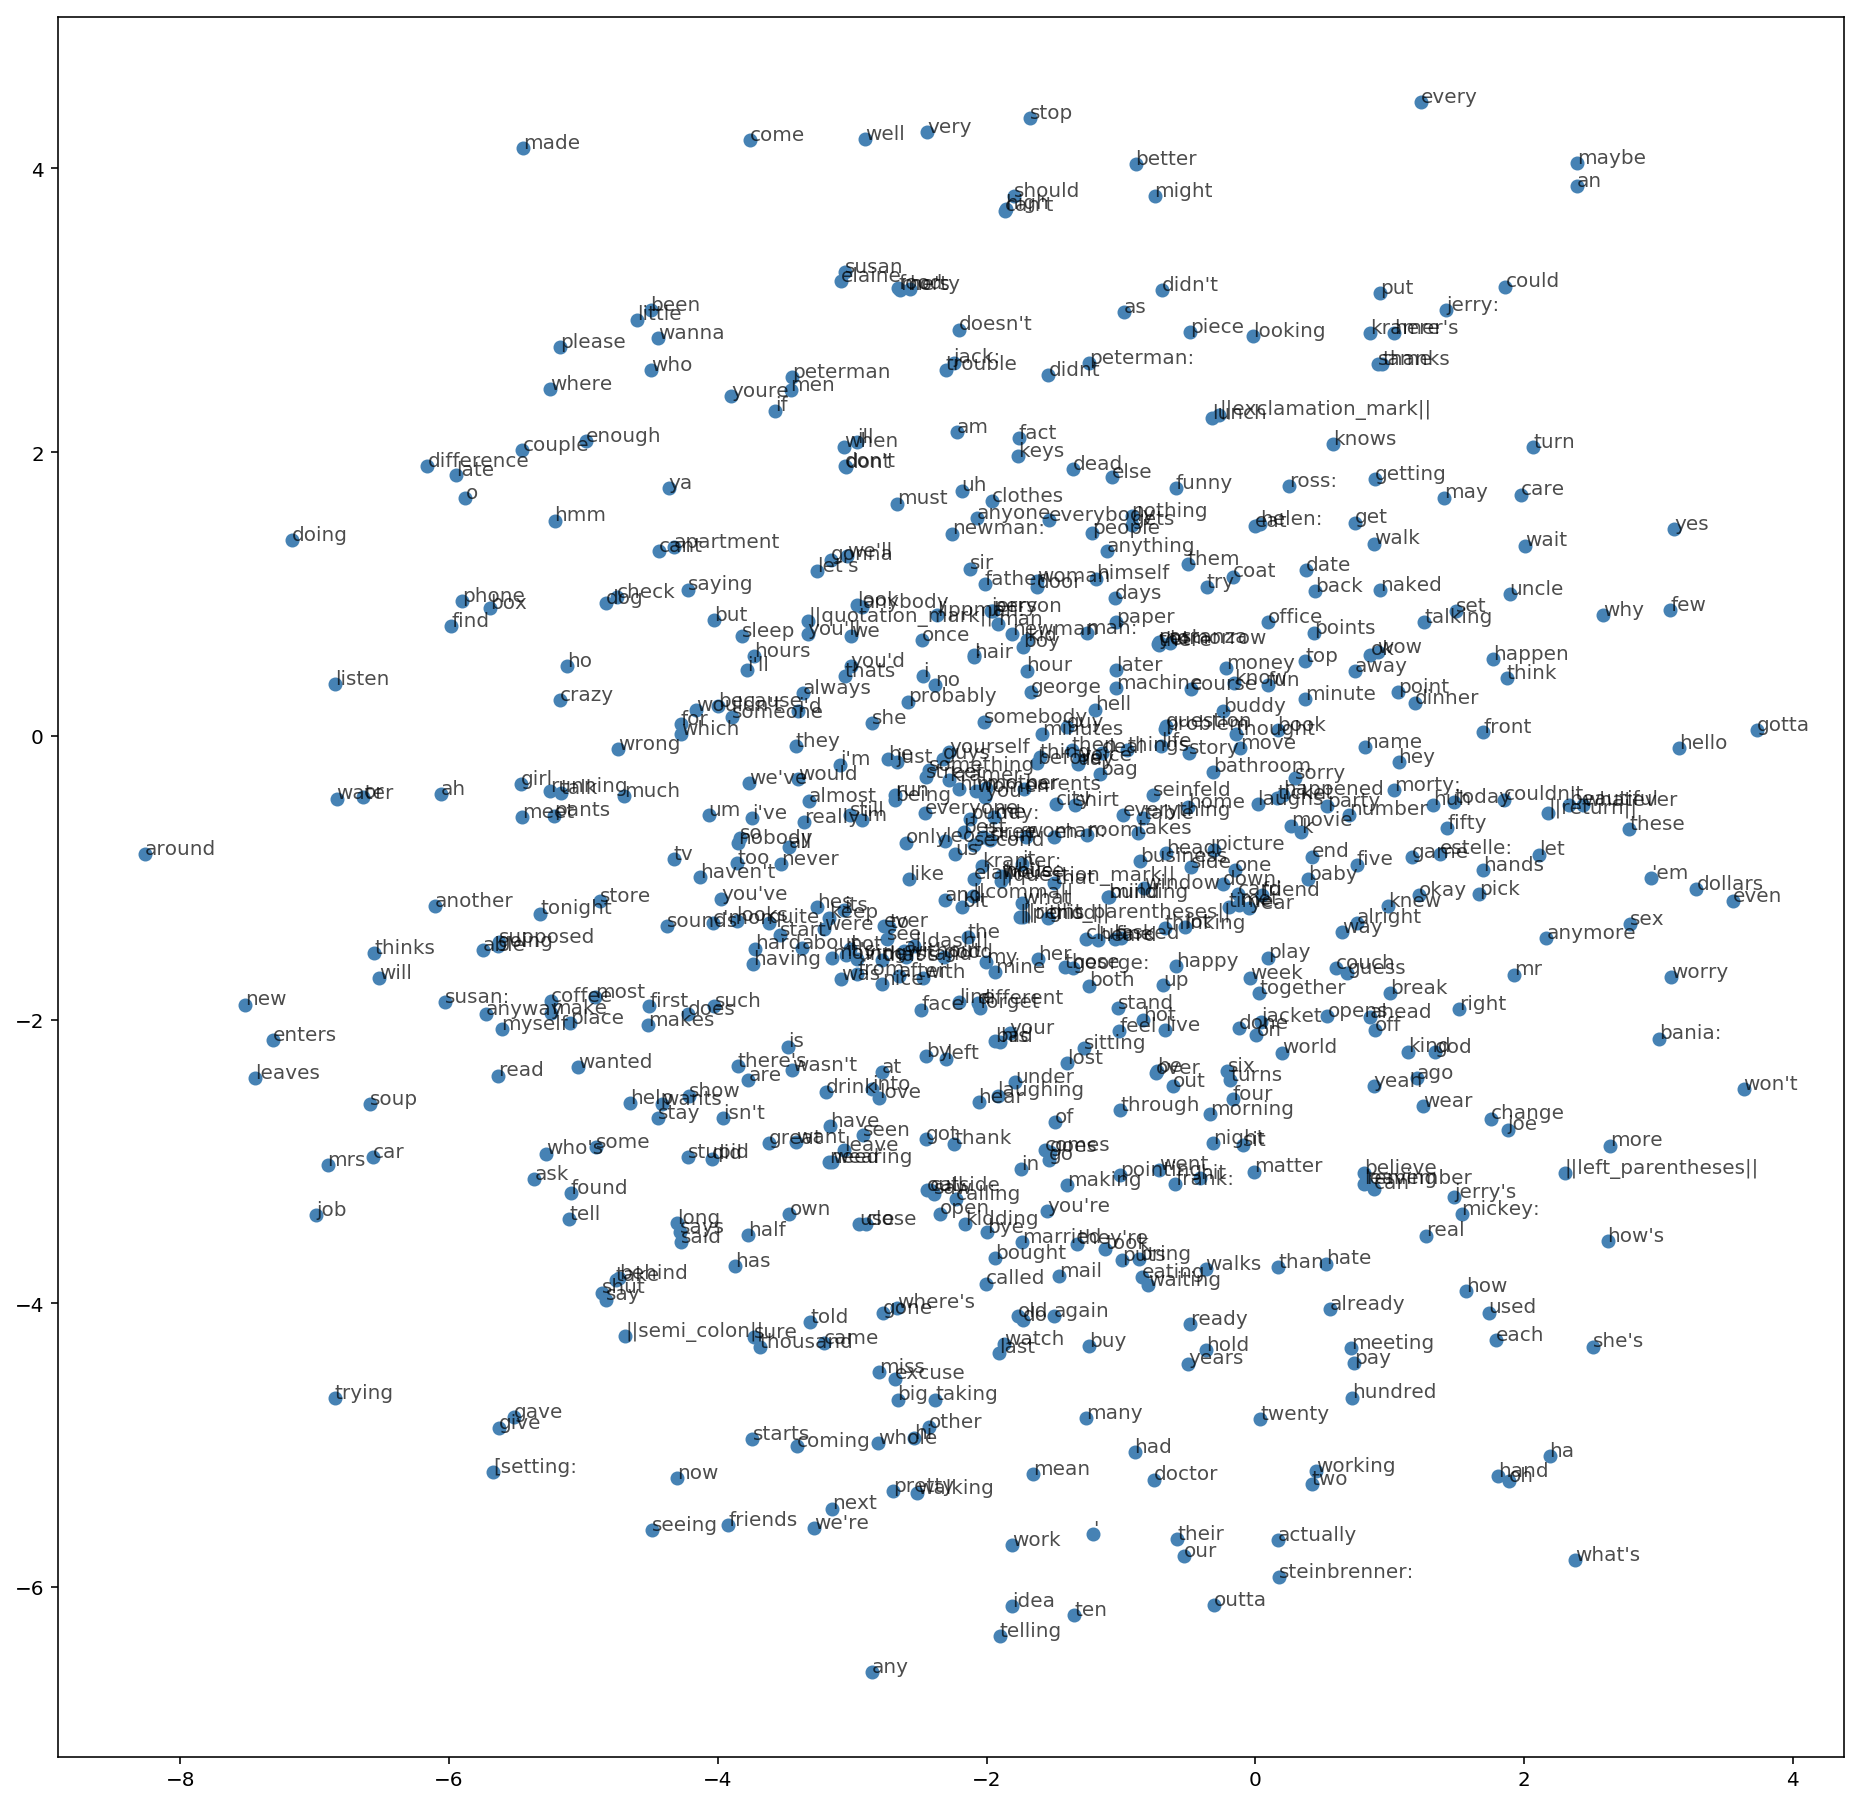

In [147]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)